## Running decoding with `pylabianca`
This notebook offers an overview of the decoding capabilities of `pylabianca` package.

In [1]:
import os
import os.path as op

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylabianca as pln

# temp for tests:
%load_ext autoreload
%autoreload 2

## Read and epoch data
We first do some of the steps discussed in `intro_overview.ipynb` tutorial. Take a look there for explanation of the code below if you don't find it sufficiently clear:

In [7]:
data_dir = r'C:\Users\Ola Kołodziej\Dropbox\Sarenka\PROJECTS\pylabianca\labianca_data\sub-U04_task-switchorder'
spike_data_dir = op.join(data_dir, 'sub-U04_ses-main_task-switchorder_run-01_sorter-osort_norm-False')

spk = pln.io.read_osort(spike_data_dir, waveform=False, format='mm')
events = pln.io.read_events_neuralynx(data_dir, format='mne')

# removing units
units_to_drop = pln.utils.read_drop_info(spike_data_dir + '_drop.txt')
pln.utils.drop_cells_by_channel_and_cluster_id(spk, units_to_drop)

sel = spk.n_spikes() >= 250
spk.pick_cells(sel)

# epoching
event_id = [10, 11, 12, 13]
main_start = np.where(events[:, -1] == 152)[0][0]
events_main = events[main_start:]
spk_epochs = spk.epoch(events_main, event_id, tmin=-0.5, tmax=2.)

# adding metadata
is_img = np.in1d(events_main[:, -1], event_id)
image_id = events_main[is_img, -1] - 10
spk_epochs.metadata = pd.DataFrame({'image': image_id})

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 328.42it/s]


## Add brain region information
We also add information about brain region that given unit was recorded from:

In [11]:
channel_info = pd.read_excel(op.join(data_dir, 'sub-U04_channels.xlsx'))
pln.io.add_region_from_channel_ranges(
    spk_epochs, channel_info, source_column='area',
    target_column='region', channel_column='channel'
)

# we now have 'region' column in the cellinfo:
spk_epochs.cellinfo.head()

,channel,cluster,alignment,threshold,region
0,A130,4599,max,5.0,LAMY
1,A130,4773,max,5.0,LAMY
2,A130,4575,max,5.0,LAMY
3,A132,5040,max,5.0,LAMY
4,A132,5018,max,5.0,LAMY


## Compute firing rate and run decoding

We compute firing rate separately for hippocampus and amygdala units, but grouping units from left and right of each of these two regions together:

In [12]:
frate = dict()
for sel_region in ['HIP', 'AMY']:
    both_regions = ['L' + sel_region, 'R' + sel_region]
    spk_sel = spk_epochs.copy().pick_cells(query=f'region in {both_regions}')
    frate[sel_region] = spk_sel.spike_density(fwhm=0.35)

(we could also compute the firing rate on all units and later use xarray query method).

Firing rate (spike density) array is three-dimensional, with the following dimensions:

In [13]:
frate['HIP'].dims

('cell', 'trial', 'time')

We want to classify image identity based on firing rate of units. The image identity was added with metadata to `SpikeEpochs` object and thus was inherited by the firing rate xarray. We can see it here:

In [14]:
frate['HIP'].image

<xarray.DataArray 'image' (trial: 72)>
array([0, 3, 2, 3, 1, 3, 2, 2, 1, 2, 0, 1, 1, 2, 0, 1, 2, 0, 1, 3, 0, 3,
       3, 2, 2, 3, 1, 3, 2, 1, 3, 1, 3, 2, 3, 3, 0, 0, 1, 0, 2, 0, 2, 1,
       3, 3, 0, 3, 3, 1, 2, 1, 2, 2, 2, 0, 1, 1, 3, 0, 2, 1, 0, 0, 3, 1,
       0, 0, 2, 0, 0, 0], dtype=int64)
Coordinates:
  * trial    (trial) int32 0 1 2 3 4 5 6 7 8 9 ... 62 63 64 65 66 67 68 69 70 71
    image    (trial) int64 0 3 2 3 1 3 2 2 1 2 0 1 1 ... 2 1 0 0 3 1 0 0 2 0 0 0

There are three images to classify, so random performance would be around 33%.  
Let's run the decoding, using the default Support Vector Classifier. We will use `pln.decoding.run_decoding` which takes an xarray as first input. We also specify the name of the coordinate to use as taget (here: `target='image'`), decimation and number of jobs to use in parallel (`n_jobs=4`).

In [15]:
score = pln.decoding.run_decoding(
    frate['HIP'], target='image', decim=10, n_jobs=4)

Because we used `decim=10` we now have 10 times less time samples:

In [16]:
print('original number of time samples:', frate['HIP'].time.shape[0])
print('number of time samples in `score`:', score.time.shape)

original number of time samples: 805
number of time samples in `score`: (81,)


Now we will visualize the decoding accuracy in time using xarray plotting. We first average the folds dimension (`.mean(dim='fold')`) and use the `.plot()` method. We'll also create a simple function to add random performace level to the plot and set y axis limits.

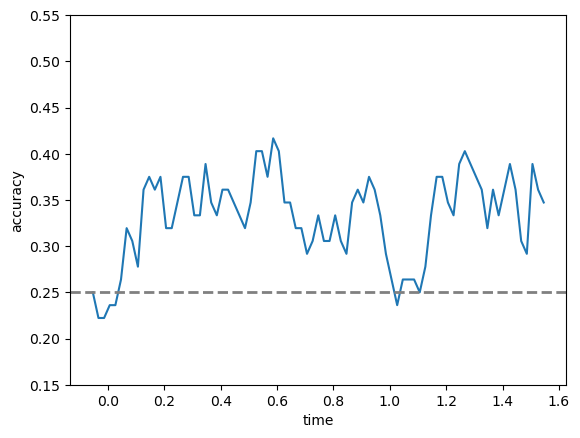

In [31]:
def format_axis(ax):
    random_performance = 1 / 4
    ax.axhline(random_performance, lw=2, color='gray', ls='--')    
    ax.set_ylim(0.15, 0.55)


lines = score.mean(dim='fold').plot()
ax = lines[0].axes
format_axis(ax)

We see that around 400 - 650 ms poststimulus image identity can be decoded with higher than chance accuracy.  
To say whether this difference is significant we would have to run a permutation control for example. We do it later in this example, but now let's run decoding for amygdala too and compare both decoding traces:

In [32]:
score2 = pln.decoding.run_decoding(
    frate['AMY'], target='image', decim=10, n_jobs=4)

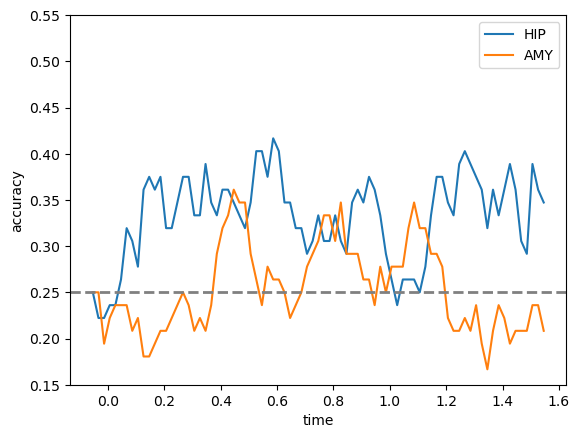

In [33]:
lines = score.mean(dim='fold').plot(label='HIP')
score2.mean(dim='fold').plot(label='AMY')

ax = lines[0].axes
format_axis(ax)
plt.legend()

We see that can decode image information both from hippocampus and amygdala units in a similar time window. Note that this effect may be due to just a few image selective cells present in both populations of neurons (also see the `intro_overview.ipynb` notebook where we look at units with good image selectivity).  

## Using maxCorr
We can compre the performance for amygdala units, when we switch from the default support vector classifier to MaxCorr:

In [34]:
mx_corr = pln.decoding.maxCorrClassifier()
scores_mxc = pln.decoding.run_decoding(
    frate['HIP'], target='image', n_jobs=4, decim=10, clf=mx_corr)

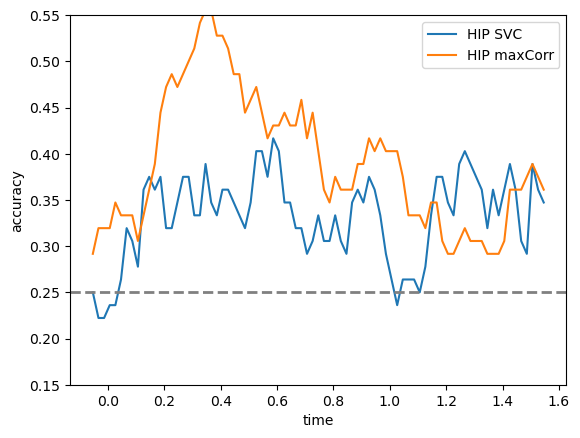

In [35]:
ax = score.mean(dim='fold').plot(label='HIP SVC')[0].axes
scores_mxc.mean(dim='fold').plot(label='HIP maxCorr')

format_axis(ax)
plt.legend()

Quite surprisingly maxCorr does far better than SVC - this may be related to default regularization of SVC being not optimal for the task.

Because we have the folds dimension from the decoding we could use `pln.viz.plot_shaded` (although it is not spike rate) to plot not only averages but also standard errors from folds (with 6 folds that's not a very good estimation of standard error though):

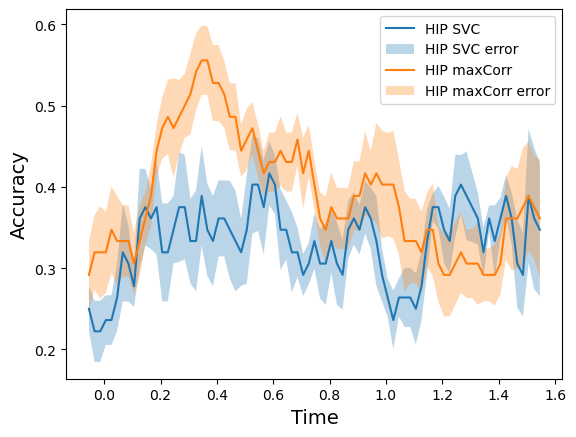

In [38]:
ax = pln.viz.plot_shaded(score, reduce_dim='fold')
pln.viz.plot_shaded(scores_mxc, reduce_dim='fold', ax=ax)
ax.legend(['HIP SVC', 'HIP SVC error', 'HIP maxCorr', 'HIP maxCorr error'])

## Time generalization decoding
Before we perform the time-consuming permutation control let's take a look at the time-generalization for amygdala cells, this may take a few seconds:

In [46]:
mx_corr = pln.decoding.maxCorrClassifier()
scores_timegen = pln.decoding.run_decoding(
    frate['HIP'], target='image', n_jobs=6, decim=10,
    time_generalization=True, clf=mx_corr
)

The outcome array is `n_folds x n_samples x n_samples`:

In [47]:
print(scores_timegen.dims)
print(scores_timegen.shape)

('fold', 'train_time', 'test_time')
(6, 81, 81)


Let's plot the outcome:

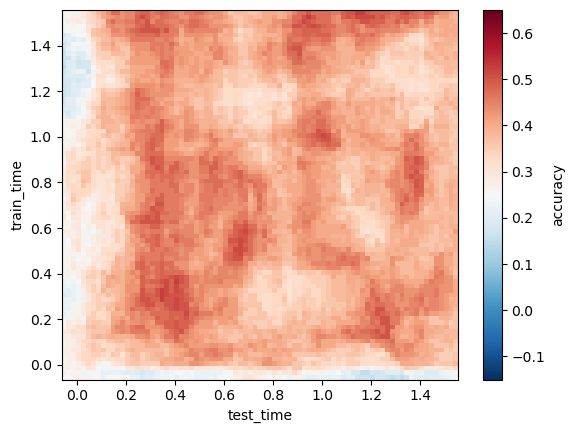

In [50]:
random_performance = 1 / 4
scores_timegen.mean(dim='fold').plot(
    vmin=random_performance - 0.4, vmax=random_performance + 0.4,
    cmap='RdBu_r'
)

the neural pattern that allows to discriminate the images is highly generalizible.  

Let's see how that looks for SVC with a slightly different regularization parameter `C`.

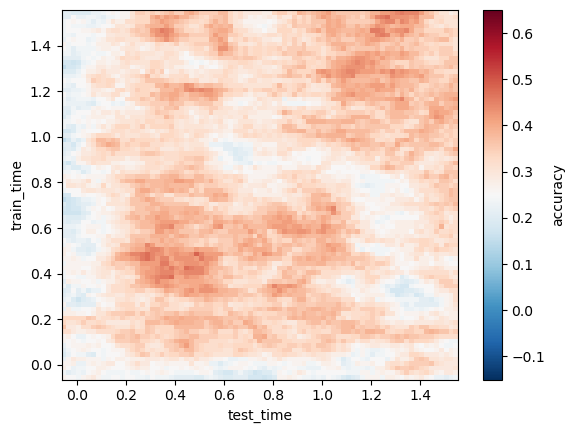

In [54]:
scores_timegen2 = pln.decoding.run_decoding(
    frate['HIP'], target='image', n_jobs=6, decim=10,
    time_generalization=True, C=0.2
)
scores_timegen2.mean(dim='fold').plot(
    vmin=random_performance - 0.4, vmax=random_performance + 0.4,
    cmap='RdBu_r'
)

## Permutation control

This may take a few minutes...

In [57]:
mx_corr = pln.decoding.maxCorrClassifier()
scores_perm = pln.decoding.permute(
    frate['HIP'], decoding_fun=pln.decoding.run_decoding,
    target='image', n_permutations=100, n_jobs=6,
    arguments=dict(decim=10, clf=mx_corr)
)

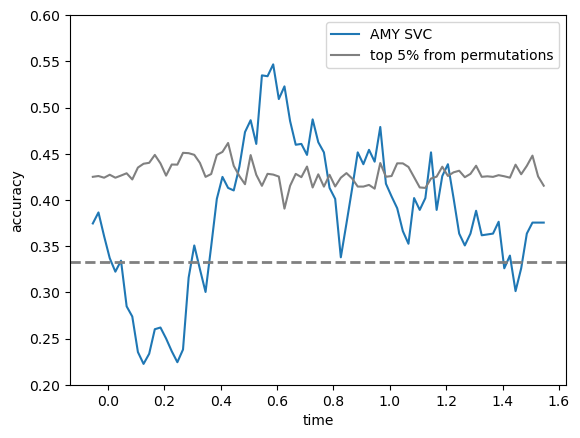

In [64]:
perm_top = np.percentile(scores_perm, 95, axis=0)

ax = score2.mean(dim='fold').plot(label='AMY SVC')[0].axes
plt.plot(scores_perm.time, perm_top, color='gray', label='top 5% from permutations')

format_axis(ax)
plt.legend()

Duging the 0.5 - 0.8 s time window the decoding performance is higher than chance (at least using this one-sided permutation test).